<a href="https://colab.research.google.com/github/Jihyun13579/ESAA/blob/main/0918(%EC%9B%94)_%EA%B3%BC%EC%A0%9C_%ED%95%B8%EC%A6%88%EC%98%A8_7%EC%9E%A5_%EC%95%99%EC%83%81%EB%B8%94_%ED%95%99%EC%8A%B5%EA%B3%BC_%EB%9E%9C%EB%8D%A4_%ED%8F%AC%EB%A0%88%EC%8A%A4%ED%8A%B8_p_245_271_%ED%95%84%EC%82%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0918(월) 과제_핸즈온 7장 앙상블 학습과 랜덤 포레스트 p. 245-271 필사
### 2129014 박지현

**앙상블 학습** : 일련의 예측기(분류, 회귀 모델...)로부터 예측을 수집하면 가장 좋은 모델 하나보다 더 좋은 예측을 얻을 수 있을 것이라는 가정 하의 학습 (cf. 대중의 지혜)
- 프로젝트의 마지막에 다다르면 흔히 앙상블 방법을 사용함
- **앙상블 학습기** : 앙상블 기법을 적용시킨 일련의 예측기
- **앙상블 방법** : 앙상블 학습 알고리즘
- **랜덤 포레스트** : 결정 트리의 앙상블
 - 오늘날 가장 강력한 머신러닝 알고리즘 중 하나



## 7.1 투표 기반 분류기

**직접 투표(hard voting)**
: 여러 개의 분류기를 훈련시킨 후, 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측하는 것 (다수결 투표)
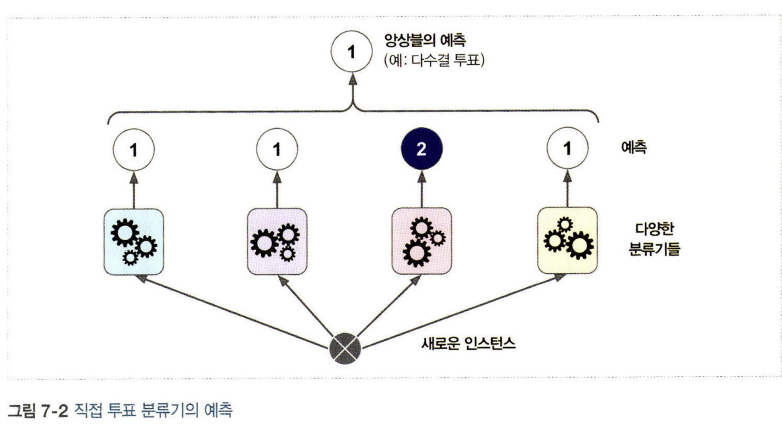

- 각 분류기가 약한 학습기(=랜덤 추측보다 조금 더 높은 성능을 내는 분류기)일지라도 충분히 많고 다양하다면, 앙상블은 강한 학습기(=높은 정확도) 될 수 있음
 - Why? 통계학의 '큰 수의 법칙(law of large numbers)' : 큰 모집단에서 무작위로 뽑은 표본의 평균은, 표본의 수가 많을수록 전체 모집단의 평균과 가까워지게 된다.
 - ex. 모든 분류기가 완벽하게 독립적이고 오차 관계가 없을 때, 51% 정확도를 가진 1000개의 분류기로 앙상블 모델 구축 시 : 약 75%의 정확도 기대 가능
 - but, 같은 데이터로 훈련시킬 시, 같은 종류의 오차 만들기 쉬움 > 위의 가정 맞지 X, 앙상블의 정확도가 낮아짐

#### 여러 분류기를 조합하여 사이킷런의 투표 기반 분류기(VotingClassifier) 만들고 훈련시키기

- 5장 : moons 데이터셋 생성하기

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=100, noise=0.15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

- 분류기를 생성하고 훈련시키기

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
                voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

- 각 분류기의 테스트셋 정확도를 확인하기

In [3]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred=clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.9
RandomForestClassifier 0.95
SVC 0.95
VotingClassifier 0.95


> 결과 : 투표 기반 분류기가 다른 개별 분류기보다 성능이 조금 더 높음

**소프트보팅(soft voting)**
: 모든 분류기가 클래스의 확률을 예측할 수 있으면(=predict_proba 메서드가 있으면), 개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스를 예측 가능 > 확률이 높은 투표에 비중을 더 두는 간접 투표 방식
- 직접 투표 방식보다 보통 성능이 더 높음
- VotingClassifier의 옵션 voting="soft"로 바꾸어주기 + 클래스의 확률 추정 가능한 모든 분류기
 - ex. SVC : 기본값에서 클래스 확률 제공 X > 'probability=True'로 지정 필요

## 7.2 배깅과 페이스팅
- 다양한 분류기를 만드는 한 가지 방법 : 각기 다른 훈련 알고리즘을 사용하는 방법 / 같은 알고리즘을 사용하고 훈련 세트의 서브셋을 무작위로 구성하여 분류기를 각기 다르게 학습시키는 것


**배깅(baggig, bootstrap aggregating)**
: 훈련 세트에서 중복을 허용하여 샘플링하는 방식


**페이스팅(pasting)**
: 중복을 허용하지 않고 샘플링하는 방식


- 공통점 : 같은 훈련 샘플을 여러 개의 예측기에 걸쳐 사용 가능
- 차이점 : 배깅만이 한 예측기를 위해 같은 훈련 샘플 여러 번 샘플링 가능

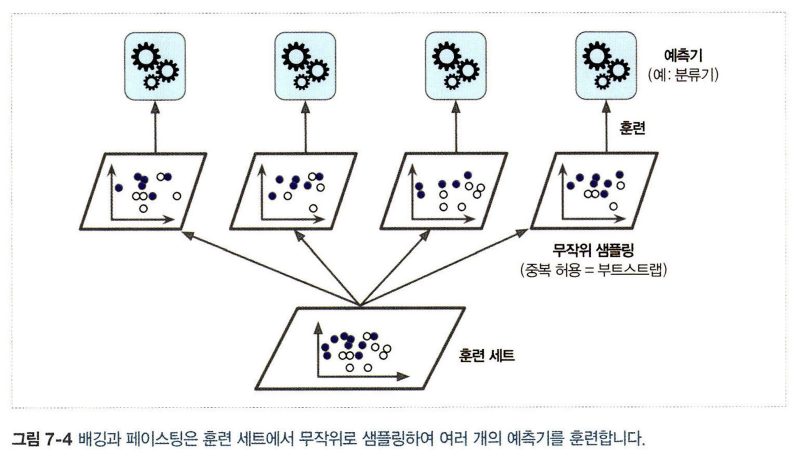

- 모든 예측기가 훈련 마칠 시, 앙상블 : 모든 예측기의 예측 모아서 새로운 샘플에 대한 예측 생성
 - 분류 : 통계적 최빈값(=직접 투표 분류기처럼 가장 많은 에측 결과)
 - 회귀 : 평균
- 개별 예측기 : 원본 훈련세트 훈련보다 훨씬 크게 편향되어 있음, but 수집함수 통과 시 편향, 분산이 모두 감소
- 앙상블 결과 : 원본 데이터셋으로 하나의 예측기 훈련 때와 편향 비슷, 분산 감소
- 예측기 : 병렬로 학습 가능, 예측 : 병렬로 수행 가능 > 이러한 확장성으로 배깅과 페이스팅 인기 높음

### 7.2.1 사이킷런의 배깅과 페이스팅

사이킷런의 BaggingClassifier(회귀 : BaggingRegressor) 이용

#### 결정 트리 분류기 500개의 앙상블 훈련시키기
- 각 분류기 : 훈련 세트에서 중복 허용해 무작위로 선택된 100개의 샘플로 훈련됨
- 페이스팅 : bootstrap=True 로 설정
- n_jobs : 훈련, 예측셍 사용할 CPU 코어 수 지정 (-1 : 가용한 모든 코어 사용)

In [4]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            max_samples=50, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

> 결과 (moons 데이터셋에서 훈련시킨 모델의 결정 경계 비교) : 앙상블의 예측이 결정 트리 하나의 예측보다 일반화가 훨씬 잘 됨
- 앙상블 : 비슷한 편향에서 더 작은 분산 생성 = 오차 수 거의 비슷하지만 결정 경계 덜 불규칙함

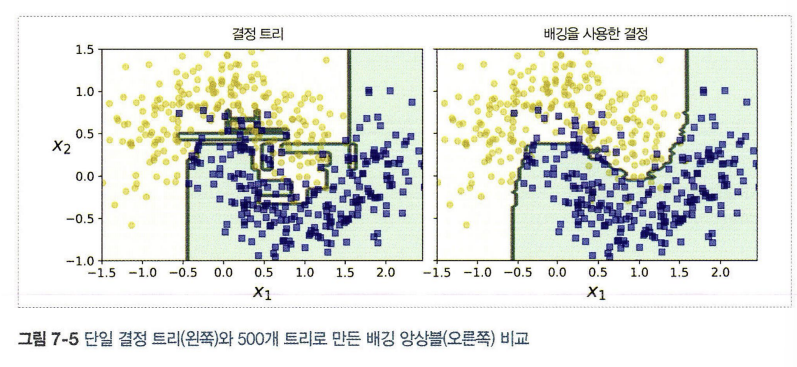


- bootstrap : 각 예측기가 학습하는 서브셋의 다양성 증가시킴
 - 배깅이 페이스팅보다 편향이 더 높아짐
 - but, 다양성 추가 = 예측기들의 상관관계 감소 = 앙상블의 분산 감소
 - 일반적으로 배깅 선호 : 배깅이 전반적으로 더 나은 모델 생성하기 때문

### 7.2.2 oob 평가
배깅 사용 시 어떤 샘플은 전혀 선택되지 않을 수 있음
- BaggingClassifier : bootstrap=True로 기본값으로 중복 허용
 - 평균적으로 각 예측기에 훈련 샘플의 63% 정도만 샘플링된다는 것 의미
 - 예측기마다 남겨진 샘플들은 모두 다름
- 선택되지 않은 훈련 샘플의 나머지 : **oob 샘플(out-of-bag)**


**oob 샘플(out-of-bag)**
: 훈련에 사용되지 않았으므로, 별도의 검증 세트 대신 oob 샘플 통해 평가 가능
- 앙상블 학습의 평가 : 각 예측기의 oob 평가 평균하여 얻음


- 사이킷런의 BaggingClassifier의'oob_score=True' : 훈련 끝난 후 자동으로 oob 평가 수행
 - 평가 점수 결과 : oob_score_ 변수에 저장되어 있음

In [5]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=500,
                  oob_score=True, random_state=40)

In [6]:
#평가 점수 결과 확인하기
bag_clf.oob_score_

0.925

- oob 평가 결과를 통해 테스트 세트 정확도 예측해보고, 테스트 세트에서 정확도 확인해보기

In [7]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.95

- oob 샘플에 대한 결정 함수의 값 : oob_decision_function_ 변수로 확인해보기 > 결정 함수가 각 훈련 샘플의 클래스 확률 반환

In [8]:
bag_clf.oob_decision_function_

array([[0.81111111, 0.18888889],
       [0.0984456 , 0.9015544 ],
       [0.89325843, 0.10674157],
       [0.04494382, 0.95505618],
       [1.        , 0.        ],
       [0.87209302, 0.12790698],
       [0.        , 1.        ],
       [0.96774194, 0.03225806],
       [0.17647059, 0.82352941],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.18181818, 0.81818182],
       [0.        , 1.        ],
       [0.98255814, 0.01744186],
       [0.04651163, 0.95348837],
       [0.99512195, 0.00487805],
       [0.84263959, 0.15736041],
       [0.25609756, 0.74390244],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.99473684, 0.00526316],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.97340426, 0.02659574],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.99459459, 0.00540541],
       [0.

## 7.3 랜덤 패치와 랜덤 서브스페이스

BaggingClassifier : 특성 샘플링 지원
- max_features, bootstrap_features 두 매개 변수로 조절됨
- 더 다양한 예측기를 만들며 편향을 늘리는 대신 분산을 낮추는 효과
- **랜덤 패치 방식**: 훈련 특성과 샘플을 모두 샘플링한느 것
- **랜덤 서브스페이스 방식**: 훈련 샘플을 모두 사용하고 특성은 샘플링하는 것
 - bootstrap=False & max_samples=1.0 + bootstrap_features=True & max_features=1.0보다 작게 설정

## 7.4 랜덤 포레스트
: 일반적으로 배깅(or 페이스팅) 방법을 적용한 결정 트리의 앙상블
- max_samples : 훈련 세트의 크기로 지정
- Bagging Classifier에 DecisionTreeClassifier 넣어 만드는 대신 **RandomForestClassifier** 사용 (회귀: RandomForestRegressor)

#### 500개 트리로 이뤄진 랜덤 포레스트 분류기를 여러 CPU 코어에서 훈련시키는 노드

In [9]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

**RandomForestClassifier**
: DecisionTreeClassifier의 매개변수와 앙상블 자체를 제어하는 데 필요한 BaggingClassidier의 매개 변수 모두 가지고 있음
- 트리 노드 분할 시: 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식으로 무작위성을 더 주입함
 - 트리의 다양성 상승 > 편향 늘어나는 대신, 분산을 낮추어 전체적으로 더 훌륭한 모델 생성하게 됨

#### BaggingClassifier를 사용해 앞의 RandomForestClassifier와 거의 유사하게 만든 코드

In [10]:
bag_clf=BaggingClassifier(
    DecisionTreeClassifier(max_features='auto', max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

### 7.4.1 엑스트라 트리

랜덤 포레스트의 트리의 생성 : 각 노드는 무작위로 특성의 서브셋을 만들어 분할에 사용함

**익스트림 랜덤 트리(extremely randomized trees, 앙상블, 엑스트라 트리, extra-trees)**
: 극단적으로 무작위한 트리의 랜덤 포레스트
- 더욱 무작위하게 만들기 위해 최적의 임곗값 찾는 대신 후보 특성을 사용해 무작위로 분할 > 최상의 분할 선택 방식
- 편향 증가, 분산 감소
- 모든 노드에서 특성마다 가장 최적의 임곗값 찾는 과정 생략 > 일반적인 랜덤 포레스트보다 속도 훨씬 빠름
- 사이킷런의 **ExtraTreesClassifier** 사용
 - 사용법 : RandomForestClassifier와 같음, 같은 API



### 7.4.2 특성 중요도

랜덤 포레스트의 장점 : 특성의 상대적 중요도 측정하기 쉬움
- 어떤 특성 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도 측정
- = 가중치 평균, 각 노드의 가중치는 연관된 훈련 샘플 수와 같은
- 사이킷런 : 훈련 종료 후 자동 계산 > 중요도 전체 합이 1이 되도록 결괏값 정규화
 - 결과 : feature_importances_에 저장되어 있음
- 특성을 선택해야 할 때 어떤 특성이 중요한지 빠르게 확인할 수 있어 매우 편리함

#### iris 데이터셋에 RandomForestClassifier를 훈련시키고 각 특성의 중요도를 출력하기

In [11]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.09754839055444055
sepal width (cm) 0.02528648934718913
petal length (cm) 0.42991668506332054
petal width (cm) 0.4472484350350499


#### (3장의) MNIST 데이터셋에 랜덤 포레스트 분류기 훈련시키고 각 픽셀의 중요도를 그래프로 나타낸 결과

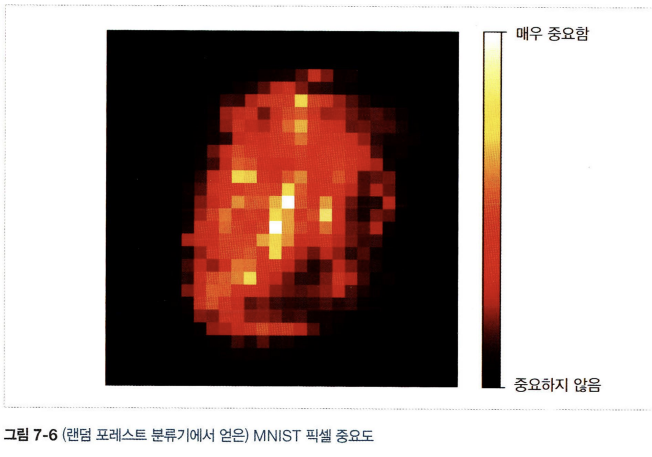

## 7.5 부스팅
: 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법

### 7.5.1 에이다부스트(AdaBoost, adaptive boosting)
: 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높이면서, 학습하기 어려운 샘플에 점점 더 맞춰가는 새로운 학습기를 만드는 방식

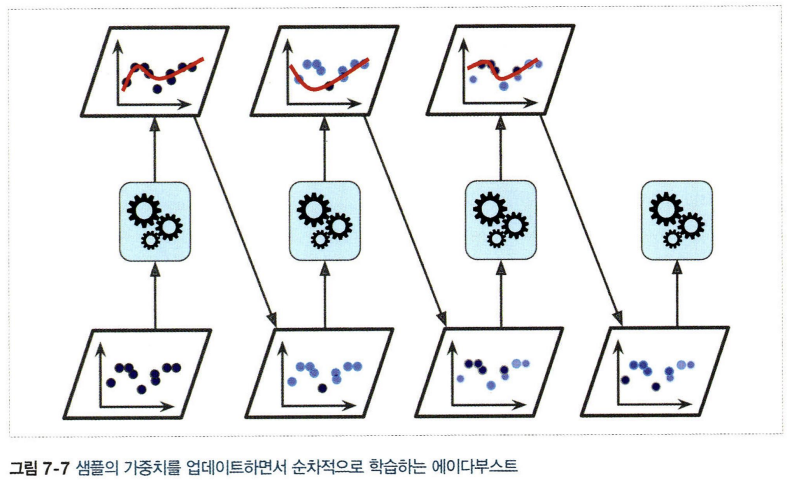

- ex. moons 데이터셋에 훈련시킨 다섯 개의 연속된 예측기의 결정 경계
> 기존 분류기의 잘못된 샘플의 가중치를 높여가며 새로운 분류기를 생성함
 - cf. 경사 하강법(비용 함수 최소화하기 위해 한 예측기의 모델 파라미터 조정), but 점차 더 좋아지도록 앙상블에 예측기를 추가하는 것

 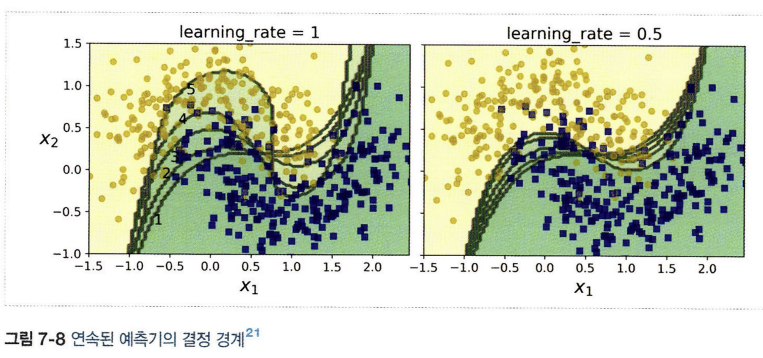

- 모든 예측기가 훈련을 마치면, 이 앙상블은 배깅/페이스팅과 비슷한 방식으로 예측 생성
 - but, 가중치가 적용된 훈련 세트의 전반적인 정확도에 따라 예측기마다 다른 가중치가 적용됨

#### 사이킷런의 AdaBoostClassifier을 사용하여 200개의 아주 얕은 결정트리 기반으로 하는 에이타부스트 분류기 훈련시키기
- AdaBoostClassifier의 기본 추정기

In [12]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

### 7.5.2 그레이디언트 부스팅
: 이전 예측기가 만든 잔여 오차(residual error)에 새로운 예측기를 학습시키면서, 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가하는 방법 (<->에이다부스트: 반복마다 샘플의 가중치 수정)

#### 결정 트리 기반 예측기로 사용하는 간단한 회귀 문제 풀어보기
- 그레이디언트 트리 부스팅(gradient tree boosting) or 그레이디언트 부스티드 회귀 트리(greadient boosted regression tree, GBRT)

0. 데이터-잡음이 섞인 2차 곡선 형태의 훈련 세트 생성하기

In [13]:
# 데이터 저장
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 2*X[:, 0]**2 + 0.05 * np.random.randn(100)

1. DecisionTreeRegressor를 훈련세트에 학습시켜 보기

In [14]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2)

2. 첫 번째 예측기에서 생긴 잔여 오차에 두 번째 DecisionTreeRegressor 훈련시키기

In [15]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

3. 두 번째 예측기에서 생긴 잔여 오차에 세 번째 DecisionTreeRegressor 회귀 모델 훈련시키기

In [16]:
y3 = y - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

> 결과 : 세 개의 트리 포함하는 앙상블 모델 생성됨

4. 테스트셋 생성하기

In [17]:
# 테스트셋 생성
X_new = np.array([[0.8]])

5. 모든 트리의 예측을 더해 새로운 샘플에 대한 예측 만들기

In [18]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

> 결과 : 트리가 앙상블에 추가될수록 앙상블의 예측이 점차 좋아지는 것 확인 가능

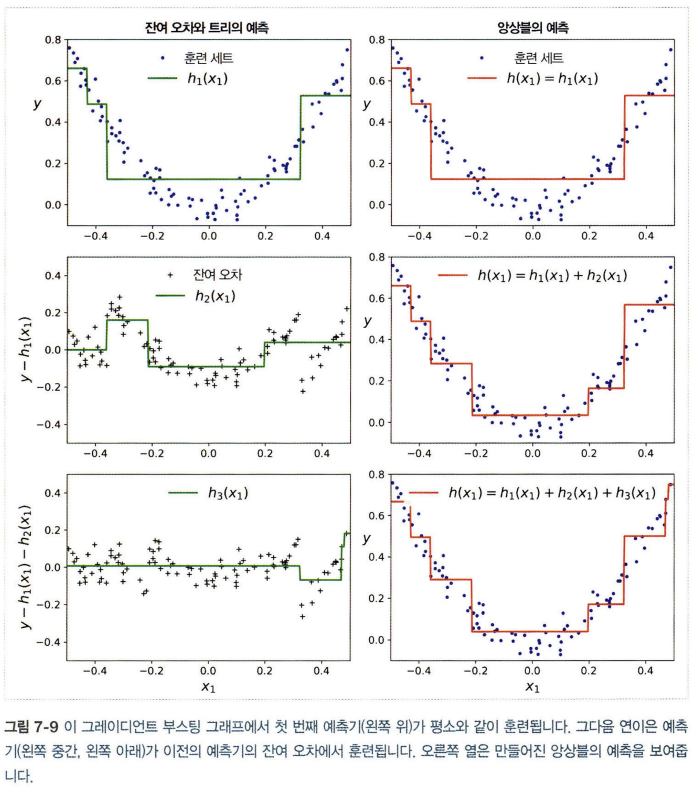

#### 사이킷런의 radientBoostingRegressor를 사용하여 GBRT 앙상블 간단하게 훈련시키기
- n_estimators : 트리 수
- max_depth, min_samples_leaf : 결정 트리의 성장을 제어
- learning_rate : 각 트리의 기여 정도 조절
 - 축소(shrinkage) : 학습률을 낮게 설정해 예측 성능을 좋게 만드는 규제 방법(많은 트리 필요)
 - 트리의 개수에 따라 과소적합/과대적합의 가능성 > **조기 종료 기법** 사용 가능

 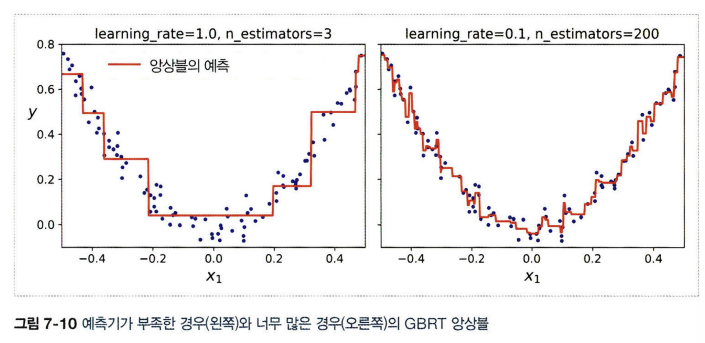

- 위에서 만든 것과 같은 앙상블을 만드는 코드

In [19]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.01)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.01, max_depth=2, n_estimators=3)

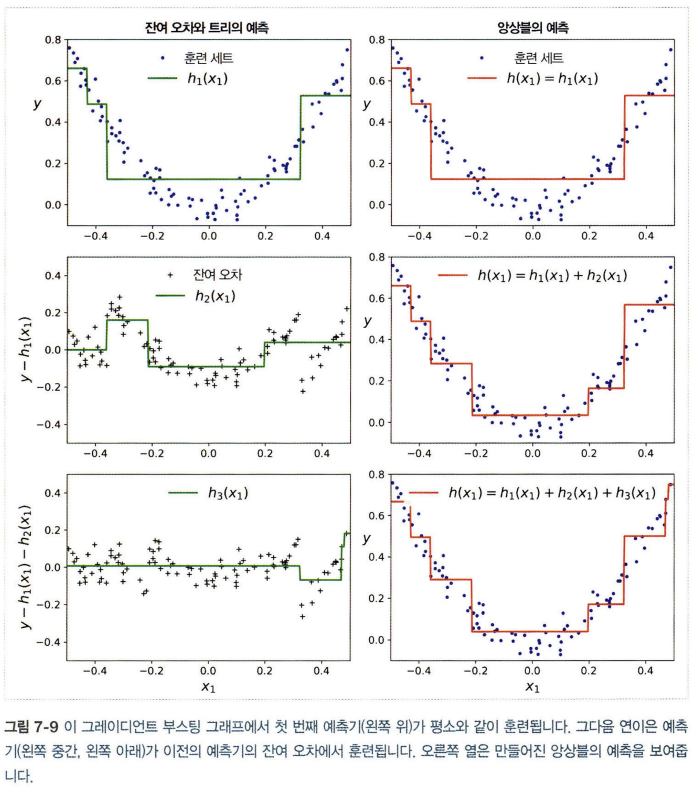

- 최적의 트리 수 찾기 위해서, **조기 종료 기법** 사용 가능

In [20]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=68)

In [21]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # 조기 종료

#### XGBoost(eXtreme Greadient Boosting) : 최적화된 그레이디언트 부스팅을 구현한 파이썬 라이브러리
- 패키지의 목표 : 매우 빠른 속도, 확장성, 이식성

In [22]:
import xgboost

xgb_reg = xgboost.XGBRegressor(random_state=1)
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

- 자동 조기 종료와 같은 여러 좋은 기능도 제공

In [23]:
xgb_reg.fit(X_train, y_train,
            eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)

[0]	validation_0-rmse:0.23885
[1]	validation_0-rmse:0.17348
[2]	validation_0-rmse:0.12931
[3]	validation_0-rmse:0.09943
[4]	validation_0-rmse:0.08290
[5]	validation_0-rmse:0.07302
[6]	validation_0-rmse:0.06563
[7]	validation_0-rmse:0.06174
[8]	validation_0-rmse:0.05981
[9]	validation_0-rmse:0.05853
[10]	validation_0-rmse:0.05779
[11]	validation_0-rmse:0.05749
[12]	validation_0-rmse:0.05770


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


## 7.6 스태킹
: 앙상블에 속한 모든 예측을 취합하는 간단한 함수 대신 취합하는 모델을 훈련시키는 기법

**블렌더(blender, 메타 학습기 meta learner)
: 홀드 아웃 세트(훈련 세트 2개의 서브셋으로 나누어 train, val로 사용하는 것) 사용하여 훈련하는 스태킹 방식

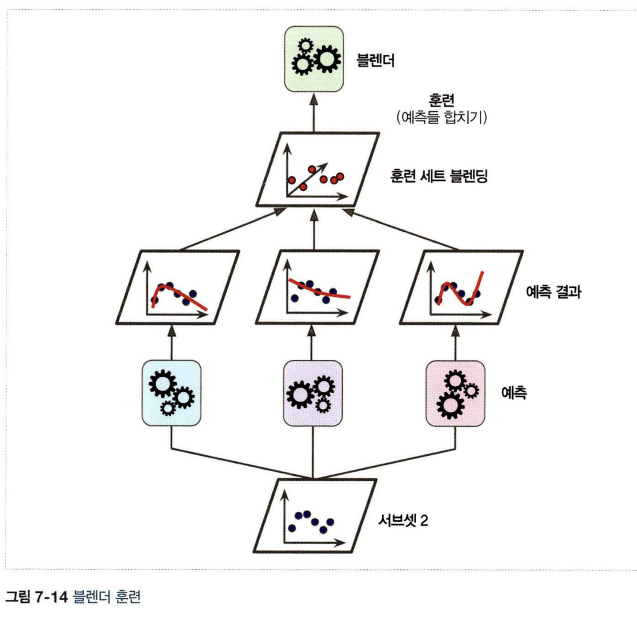